In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|default_exp converter.cocov2

# Coco converter.

> Convert dataset formats.

In [ ]:
#|export
from fastcore.all import *
import cv2
import shutil
import numpy as np
import polvo as pv

/home/michael/git/polvo/polvo/utils/logging.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/michael/Downloads/yes/envs/pokev2.1.copy2/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/michael/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:20


In [ ]:
#|export
class COCOV2(pv.Visitor):
    def _initial_json(self):
        return {
            'info': {'year': '', 'version': ''},
            'licenses': [{'id': 0, 'url': '', 'name': ''}],
            'categories': [],
            'images': [],
            'annotations': []}
    
    def convert_record(self, record, image_dir, ann_dir):
        ...
    
    def convert_records(self, save_dir, records, n_workers=defaults.cpus):
        ...
#         image_dir = pv.mkdir(Path(save_dir)/'images')
#         ann_dir = pv.mkdir(Path(save_dir)/'labels')
        # Parallel might be problematic with current implementation
        # it might get wrong indices when doing len(self._json['images'])
#         parallel(pv.partial(self.convert_record, image_dir=image_dir, ann_dir=ann_dir),
#                  records, progress=pv.pbar, n_workers=n_workers)

        
    def dataset_json(self, records, dataset_class_map):
        self._dataset_class_map = dataset_class_map
        self._json = self._initial_json()
        self._add_categories(dataset_class_map)
        for record in records: self.record_json(record)
        return self._json
    
    def _add_categories(self, class_map):
        for i, name in class_map.id2name.items(): 
            self._json['categories'].append({'id': i, 'name': name, 'supercategory': ''})
        
    def record_json(self, record):
        self._labels, self._bboxes = [], []
        self.visit_all(record)
        
    def _visit_image_file(self, image_file): 
        self._w,self._h = pv.image_size(image_file)
        self._image_file = image_file
        self._image_id = len(self._json['images'])+1
        self._json['images'].append({
            'id': self._image_id,
            'license': 0,
            'file_name': self._image_file.name,
            'height': self._h,
            'width': self._w,
        })
    
    def _visit_bbox_labelled(self, bbox):
        annotation_id = len(self._json['annotations'])
        self._json['annotations'].append({
            'id': annotation_id,
            'image_id': self._image_id,
            'category_id': self._dataset_class_map.name2id[bbox.label.name],
            'bbox': bbox.xyxy.astype(int).tolist(),
            'area': int(bbox.area),
            'segmentation': [bbox.flat.astype(int).tolist()],
            'iscrowd': 0
        })

    def _visit_obbox_labelled(self, obbox):
        annotation_id = len(self._json['annotations'])
        self._json['annotations'].append({
            'id': annotation_id,
            'image_id': self._image_id,
            'category_id': self._dataset_class_map.name2id[obbox.label.name],
            'bbox': obbox.xyxy.astype(int).tolist(),
            'area': int(obbox.area),
            'segmentation': [obbox.flat.astype(int).tolist()],
            'iscrowd': 0
        })
        
    def _visit_segmask(self, segmask):
        contours = segmask.to_contours()
        for label, contour in contours.items():
            for c in contour:
                dataset_catid = self._dataset_class_map.name2id[label]
                self._json['annotations'].append(self._contour_to_annotation(c, dataset_catid))

    def _contour_to_annotation(self, contour, category_id):
        assert contour.shape[1] == 1 #i'm not sure i can just ignore the 2nd dim
        contour = contour[:, 0, :]
        # segmentation
        polygon = contour.ravel().tolist()
        # bbox
        xmax, ymax = contour.max(axis=0).tolist()
        xmin, ymin = contour.min(axis=0).tolist()
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]

        annotation_id = len(self._json['annotations'])
        return {
            'id': annotation_id,
            'image_id': self._image_id,
            "category_id": category_id,
            "segmentation": [polygon],
            "bbox": bbox,
            "iscrowd": 0,
        }

In [ ]:
import polvo.bbox as pb
import polvo.segmask as ps

In [ ]:
image_file = pv.ImageFile(str(pv.test.SEG_IMAGE))
class_map = {0: 'test0', 1: 'test1'}
labels = [pv.Label(i, class_map[i]) for i in [0, 1, 1]]
bboxes = [pb.BBox.from_xyxy(20, 20, 64, 280),
          pb.BBox.from_xywh(10, 72, 478, 72),
          pb.BBox.from_relative_xcycwh(.4, .4, .7, .6, 512, 300),
         ]
bboxesl = [pb.BBoxLabeled(bbox, label) for bbox, label in pv.safe_zip(bboxes, labels)]

olabels = [pv.Label(i, class_map[i]) for i in [0]]
obboxes = [pb.OBBox.from_clockwise(256,175, 100,140, 80),]
obboxesl = [pb.OBBoxLabeled(obbox, label) for obbox, label in pv.safe_zip(obboxes, olabels)]

In [ ]:
dataset_class_map = pv.ClassMap(pv.Label(6, 'test0'), pv.Label(7, 'test1'), pv.Label(50, 'seg1'), pv.Label(0, 'background'))

<AxesSubplot:>

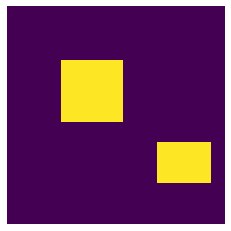

In [ ]:
seg_class_map = pv.ClassMap(pv.Label(0, 'background'), pv.Label(1, 'seg1'))
mask = np.zeros((32, 32), dtype=np.uint8)
mask[8:17, 8:17] = 1
mask[20:26, 22:30] = 1
mask = ps.SegMask(mask, seg_class_map)
pv.show_image(mask.mask)

In [ ]:
record = [image_file, *bboxesl, *obboxesl, mask]
converter = COCOV2()
# converter.convert_record(record)

In [ ]:
#|export
# temporary
import cv2

In [ ]:
json = converter.dataset_json([record], dataset_class_map)

In [ ]:
json

{'info': {'year': '', 'version': ''},
 'licenses': [{'id': 0, 'url': '', 'name': ''}],
 'categories': [{'id': 6, 'name': 'test0', 'supercategory': ''},
  {'id': 7, 'name': 'test1', 'supercategory': ''},
  {'id': 50, 'name': 'seg1', 'supercategory': ''},
  {'id': 0, 'name': 'background', 'supercategory': ''}],
 'images': [{'id': 1,
   'license': 0,
   'file_name': 'image1.png',
   'height': 332,
   'width': 500}],
 'annotations': [{'id': 0,
   'image_id': 1,
   'category_id': 6,
   'bbox': [20, 20, 64, 280],
   'area': 11440,
   'segmentation': [[20, 20, 64, 20, 64, 280, 20, 280]],
   'iscrowd': 0},
  {'id': 1,
   'image_id': 1,
   'category_id': 7,
   'bbox': [10, 72, 488, 144],
   'area': 34416,
   'segmentation': [[10, 72, 488, 72, 488, 144, 10, 144]],
   'iscrowd': 0},
  {'id': 2,
   'image_id': 1,
   'category_id': 7,
   'bbox': [26, 30, 384, 210],
   'area': 64440,
   'segmentation': [[26, 30, 384, 30, 384, 210, 26, 210]],
   'iscrowd': 0},
  {'id': 3,
   'image_id': 1,
   'catego

In [ ]:
pv.save_json(json, pv.mkdir('test', tmp=True, overwrite=True)/'annotation.json')

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()